In [18]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
import h5py
import pandas as pd
import numpy as np
import csv
from source.wsi import WholeSlideImage
import multiprocessing as mp
import patchify
import matplotlib.pyplot as plt

Already extracted the 4kx4k regions using HS2P, now gotta check how many regions we have in total and per class

In [8]:
running_in= '/data/pathology'#'/mnt/CPG'
examode_regiondir = Path(f'{running_in}/projects/pathology-self-supervision/data/examode_colon/')
#get all csv files with 'tiles' in the name and with 'region' in the path
csv_files = list(examode_regiondir.glob('*region*/*tiles.csv'))
for f in csv_files:
    print(f)

/data/pathology/projects/pathology-self-supervision/data/examode_colon/cancer_hgd_lgd_region_0.5_4096/tiles.csv
/data/pathology/projects/pathology-self-supervision/data/examode_colon/non_cancer_hgd_lgd_region_0.5_4096/tiles.csv
/data/pathology/projects/pathology-self-supervision/data/examode_colon/cancer_lgd_region_0.5_4096/tiles.csv
/data/pathology/projects/pathology-self-supervision/data/examode_colon/non_cancer_lgd_region_0.5_4096/tiles.csv
/data/pathology/projects/pathology-self-supervision/data/examode_colon/cancer_wo_d_region_0.5_4096/tiles.csv
/data/pathology/projects/pathology-self-supervision/data/examode_colon/non_cancer_hgd_region_0.5_4096/tiles.csv
/data/pathology/projects/pathology-self-supervision/data/examode_colon/cancer_hgd_region_0.5_4096/tiles.csv
/data/pathology/projects/pathology-self-supervision/data/examode_colon/non_cancer_wo_d_region_0.5_4096/tiles.csv


In [13]:
all_regions=0
for file in csv_files:
    with open(file, 'r') as f:
        #ignore the header
        next(f)
        reader = csv.reader(f)
        name=('_').join(file.parent.stem.split('_')[:-2])
        sum_class = sum(1 for row in reader)
        print(f'{name} : {sum_class}')
        all_regions+=sum_class
print(f'Total regions extracted: {all_regions}')

cancer_hgd_lgd : 526
non_cancer_hgd_lgd : 9468
cancer_lgd : 834
non_cancer_lgd : 82640
cancer_wo_d : 24580
non_cancer_hgd : 13542
cancer_hgd : 7047
non_cancer_wo_d : 205203
Total regions extracted: 343840


In [55]:
343848*256

88025088

In [10]:
lgd=pd.read_csv(csv_files[2])
lgd.groupby('slide_id').count()

,tile_size,spacing,level,level_dim,x,y,contour
slide_id,,,,,,,
EX_S03_P000203_C0001_B1,120,120,120,120,120,120,120
EX_S03_P001256_C0001_B4,362,362,362,362,362,362,362
EX_S03_P003208_C0001_B1,68,68,68,68,68,68,68
EX_S03_P003503_C0001_B1,55,55,55,55,55,55,55
EX_S03_P003936_C0001_B1,100,100,100,100,100,100,100
EX_S03_P004057_C0001_B1,129,129,129,129,129,129,129


## Constructing individual region_h5 files with the image tensor in the reion_h5 file

In [8]:
colon_class=['cancer_wo_d','non_cancer_hgd','non_cancer_hgd_lgd', 'non_cancer_wo_d']
file_path=Path(f'{running_in}/projects/pathology-self-supervision/data/examode_colon/{colon_class[3]}_region_0.5_4096/patches/4096/jpeg/').rglob('*.h5')

h5_files=[x for x in file_path if x.is_file()]
print(f'Number of h5 files: {len(h5_files)}')

Number of h5 files: 4552


In [9]:
#do a csv file with the h5_files path
for colon in colon_class:
    file_path=Path(f'{running_in}/projects/pathology-self-supervision/data/examode_colon/{colon}_region_0.5_4096/patches/4096/jpeg/').rglob('*.h5')
    h5_files=[x for x in file_path if x.is_file()]
    with open(Path(f'{running_in}/projects/pathology-self-supervision/data/examode_colon/{colon}_region_4096.csv'), 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['h5_files'])
        for h5_file in h5_files:
            writer.writerow([h5_file])

In [17]:
('_').join(Path('/data/pathology/projects/pathology-self-supervision/data/examode_colon/cancer_hgd_lgd_region_4096.csv').stem.split('_')[:-2])

'cancer_hgd_lgd'

In [19]:
wsi_path = list(Path(f"{running_in}/archives/gastrointestinal/examode_biopsies_radboudumc_colon/packed_blocks_sp05/packed").rglob("*.tif"))

In [31]:
def read_region_wrapper(args):
    coord, patch_level, patch_size, wsi_path = args
    actual_wsi = WholeSlideImage(wsi_path)
    result = actual_wsi.wsi.read_region(coord, patch_level, patch_size).convert("RGB")
    result = np.array(result)
    return result

def patch_hd5(coord_dset, wsi_path, attributes):
        num_workers = mp.cpu_count()
        print(num_workers)
        if num_workers > 4:
            num_workers = 4
        patch_level=attributes['patch_level']
        patch_size=attributes['patch_size']
        with mp.Pool(num_workers) as pool:
            iterable = [(tuple(coord), patch_level, (patch_size,patch_size), wsi_path) for coord in coord_dset]
            results = pool.map(read_region_wrapper, iterable)
        results = np.array([result for result in results if result is not None])
        return results

#from h2sp/source/utils.py
def save_hdf5(output_path, asset_dict, attr_dict=None, mode="a"):
    file = h5py.File(output_path, mode)
    for key, val in asset_dict.items():
        data_shape = val.shape
        if key not in file:
            data_type = val.dtype
            chunk_shape = (1,) + data_shape[1:]
            maxshape = (None,) + data_shape[1:]
            dset = file.create_dataset(
                key,
                shape=data_shape,
                maxshape=maxshape,
                chunks=chunk_shape,
                dtype=data_type,
            )
            dset[:] = val
            if attr_dict is not None:
                if key in attr_dict.keys():
                    for attr_key, attr_val in attr_dict[key].items():
                        dset.attrs[attr_key] = attr_val
        else:
            dset = file[key]
            dset.resize(len(dset) + data_shape[0], axis=0)
            dset[-data_shape[0] :] = val
    file.close()
    return output_path

def single_hdf5_mp(args):
    coord, img, attributes, h5_file = args
    patch_size=256
    patch_dim = (patch_size, patch_size, img.shape[2])
    n_patches_dim = img.shape[0] // patch_size
    patch= patchify.patchify(img, patch_dim, step=256).reshape(n_patches_dim**2,patch_size,patch_size,3)  
    out_path=f'{h5_file.parent}/{h5_file.stem}_{str(coord[0])}_{str(coord[1])}.h5'
    attributes['save_path']=out_path
    #lets make the image into 
    asset_dict={'coords':coord,'imgs':patch}
    attr_dict={'coords':attributes,'imgs':attributes}
    attr_dict['imgs']['subpatch_size']=patch_size
    result=save_hdf5(out_path, asset_dict, attr_dict, mode="w")
    return result

In [59]:
for h5_file in h5_files:
    with h5py.File(h5_file, "r") as f:
        print(len(f))
        dset=f['coords']
        attr_wsi_dict=dict(dset.attrs.items())
        wsi_name=attr_wsi_dict['wsi_name']
        wsi_file=[x for x in wsi_path if wsi_name in x.stem][0]
        print(f'{wsi_name} has {len(dset)} regions of {attr_wsi_dict["patch_size"]}x{attr_wsi_dict["patch_size"]}')
        #imgs=patch_hd5(dset, wsi_file, attr_wsi_dict)
        #The images are already in a numpy array, lets store directlly the individual h5 file, lets use multiprocessing
        num_workers = mp.cpu_count()
        if num_workers > 4:
            num_workers = 4
        with mp.Pool(num_workers) as pool:
            iterable=[(coord,img,attr_wsi_dict,h5_file)for coord, img in zip(dset,imgs)]
            results = pool.map(single_hdf5_mp, iterable)
    print(f'{wsi_name} has been saved in {len(results)} h5 files')
    break


1
EX_S03_P003370_C0001_B2 has 79 regions of 4096x4096
EX_S03_P003370_C0001_B2 has been saved in 79 h5 files


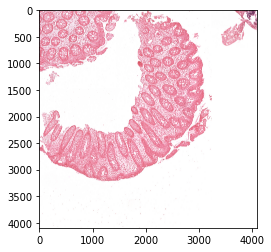

In [74]:
import matplotlib.pyplot as plt
plt.imshow(imgs[0])

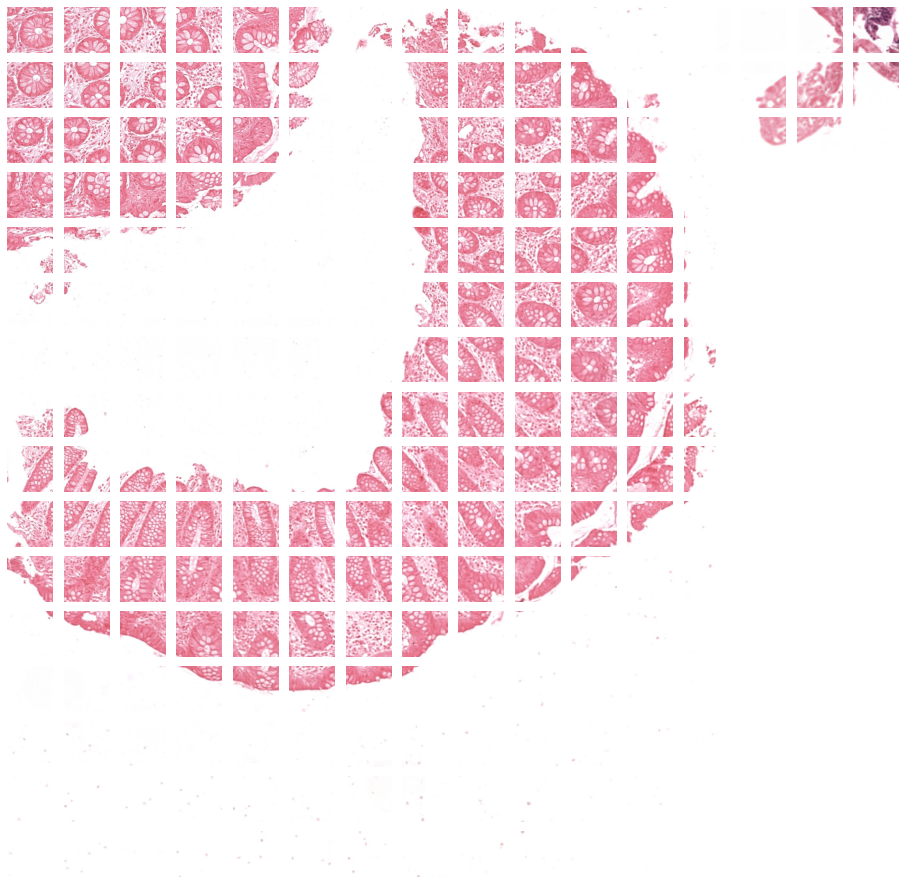

In [75]:
r=imgs[0]
patch_size=256
patch_dim = (patch_size, patch_size, r.shape[2])
n_patches_dim = r.shape[0] // patch_size
patch= patchify.patchify(r, patch_dim, step=256).reshape(n_patches_dim**2,patch_size,patch_size,3)
patch.shape
fig, ax = plt.subplots(16, 16, figsize=(16, 16))
for i in range(16):
    for j in range(16):
        ax[i, j].imshow(patch[i*16+j])
        ax[i, j].axis("off")

In [52]:
#open the h5 file and delete the imgs
with h5py.File('/data/pathology/projects/pathology-self-supervision/data/examode_colon/cancer_lgd_region_0.5_4096/patches/4096/jpeg/EX_S03_P000203_C0001_B1/EX_S03_P000203_C0001_B1.h5', "r+") as f:
    print(len(f))
# dset=f['coords']
# coordinates=dset[:].copy()
# #save in the file the attributes and the coords
# attr_wsi_dict=dict(dset.attrs.items())
# save_hdf5(Path('/data/pathology/projects/pathology-self-supervision/data/examode_colon/cancer_lgd_region_0.5_4096/patches/4096/jpeg/EX_S03_P000203_C0001_B1/EX_S03_P000203_C0001_B1.h5'), {'coords':coordinates}, {'coords':attr_wsi_dict}, mode="w")


0


Checking if it got stored correctly

2
[29440 45312]
downsample [1. 1.]
downsampled_level_dim [48128 50688]
level_dim [48128 50688]
patch_level 0
patch_size 4096
ref_patch_size 4096
save_path /data/pathology/projects/pathology-self-supervision/data/examode_colon/cancer_lgd_region_0.5_4096/patches/4096/jpeg/EX_S03_P000203_C0001_B1/EX_S03_P000203_C0001_B1_29440_45312.h5
spacing 0.5
subpatch_size 256
wsi_name EX_S03_P000203_C0001_B1


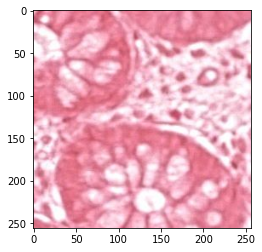

In [34]:
with h5py.File(results[0], "r") as f:
    print(len(f))
    c=f['coords']
    print(c[:])
    i=f['imgs']
    for key, val in i.attrs.items():
        print(key, val)
    plt.imshow(i[56])


## Creating a custom dataset for the H5 files

In [5]:
regionh5=pd.read_csv('/data/pathology/projects/pathology-self-supervision/data/examode_colon/processed_wsi2region_h5.csv')
regionh5['Number_of_patches'].sum()

51924480

In [74]:
h5_source=Path('/data/pathology/projects/pathology-self-supervision/data/examode_colon/region_4096_h5/')
dataset_=datasets.DatasetFolder(h5_source, loader=lambda x: h5py.File(x, 'r')['imgs'], extensions='.h5')
len(dataset_)

210822

In [75]:
len(dataset_)*256

53970432

256
(256, 256, 256, 3)
downsample [1. 1.]
downsampled_level_dim [48128 50688]
level_dim [48128 50688]
patch_level 0
patch_size 4096
ref_patch_size 4096
save_path /data/pathology/projects/pathology-self-supervision/data/examode_colon/region_4096_h5/colon_cancer_lgd/EX_S03_P000203_C0001_B1/EX_S03_P000203_C0001_B1_0_41280.h5
spacing 0.5
subpatch_size 256
wsi_name EX_S03_P000203_C0001_B1


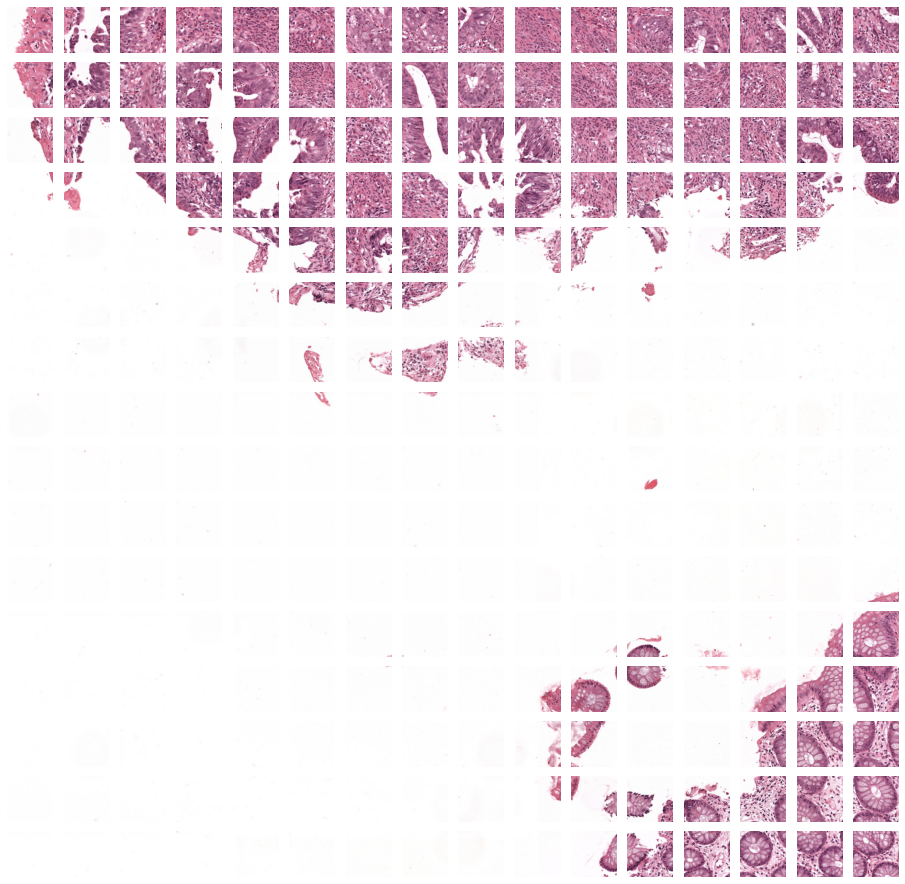

In [70]:
f,c=dataset_[1]
print(len(f))
print(f.shape)
for k,v in f.attrs.items():
    print(k,v)
fig, ax = plt.subplots(16, 16, figsize=(16, 16))
for i in range(16):
    for j in range(16):
        ax[i, j].imshow(f[i*16+j])
        ax[i, j].axis("off")

Now lets create a data set class that inherits the things from datasetfolder

In [76]:
class h5fileDataset(datasets.DatasetFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, loader=lambda x: h5py.File(x, 'r')['imgs'], extensions='.h5')
        self.patches_per_file=len(self.loader(self.samples[0][0]))
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self) -> int:
        return len(self.samples)*self.patches_per_file
    def __getitem__(self, index: int):
        file_index=index//self.patches_per_file
        patch_index=index%self.patches_per_file
        path, target = self.samples[file_index]
        sample = self.loader(path)
        sample=sample[patch_index]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target    

In [78]:
t=h5fileDataset(h5_source)
len(t)

54137856

(256, 256, 3)


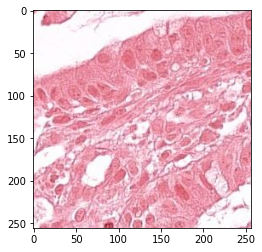

In [80]:
img,c=t[82]
print(img.shape)
plt.imshow(img)

In [81]:
sampler = torch.utils.data.RandomSampler(t)
data_loader = torch.utils.data.DataLoader(
        t,
        sampler=sampler,
        batch_size=32,
)

In [23]:
archivo = Path('/mnt/CPG/projects/pathology-self-supervision/WSI_patches/breast/BNCB/new_4096_patches/patches/100.h5')
with h5py.File(archivo,'r') as f:
    for k,v in f['coords'].attrs.items():
        print(k,v) 

downsample [1. 1.]
downsampled_level_dim [35200 24448]
level_dim [35200 24448]
name 100
patch_level 0
patch_size 4096
save_path /data/pathology/projects/pathology-self-supervision/WSI_patches/breast/BNCB/new_4096_patches/patches


In [ ]:
#probably will need to change the loader to something that read the h5 file and returns the coords contained in the file
#with clam normal patching we get 'coords' and 'imgs' keys in each h5 file, so to access the imgs we need to do something like:
#f['imgs'][0]